Device: cuda
Classes: ['Blight', 'Healthy', 'Spot']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

[Epoch 1/20] Train Acc: 0.9048 | Val Acc: 0.9872
✅ Best model saved
[Epoch 2/20] Train Acc: 0.9619 | Val Acc: 0.9744
[Epoch 3/20] Train Acc: 0.9725 | Val Acc: 0.9103
[Epoch 4/20] Train Acc: 0.9656 | Val Acc: 0.9615
[Epoch 5/20] Train Acc: 0.9810 | Val Acc: 0.9872
[Epoch 6/20] Train Acc: 0.9841 | Val Acc: 0.9744
[Epoch 7/20] Train Acc: 0.9926 | Val Acc: 0.9487
[Epoch 8/20] Train Acc: 0.9952 | Val Acc: 0.9487
[Epoch 9/20] Train Acc: 0.9942 | Val Acc: 0.9231
[Epoch 10/20] Train Acc: 0.9799 | Val Acc: 0.9231
[Epoch 11/20] Train Acc: 0.9767 | Val Acc: 0.9615
[Epoch 12/20] Train Acc: 0.9884 | Val Acc: 0.9744
[Epoch 13/20] Train Acc: 0.9899 | Val Acc: 0.9103
[Epoch 14/20] Train Acc: 0.9847 | Val Acc: 0.9744
[Epoch 15/20] Train Acc: 0.9974 | Val Acc: 0.9487
[Epoch 16/20] Train Acc: 0.9958 | Val Acc: 0.9872
[Epoch 17/20] Train Acc: 0.9783 | Val Acc: 0.9359
[Epoch 18/20] Train Acc: 0.9804 | Val Acc: 0.9744
[Epoch 19/20] Train Acc: 0.9905 | Val Acc: 0.9487
[Epoch 20/20] Train Acc: 0.9963 | Val Ac

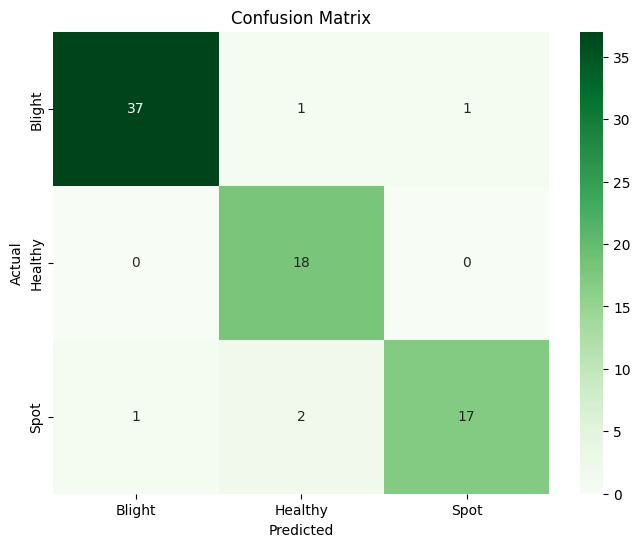

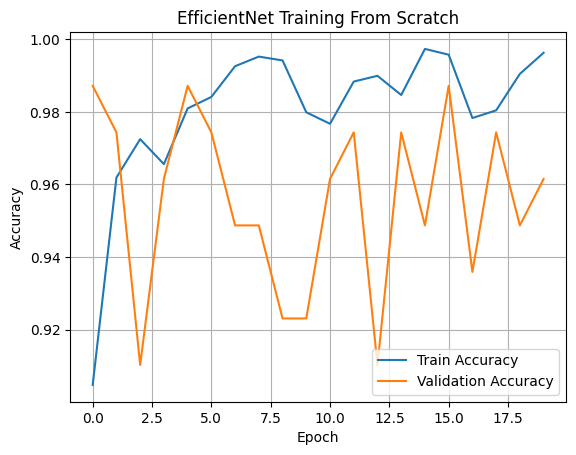

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/full_model.pth': No such file or directory
✅ ماډل په Google Drive کې ذخیره شو


In [1]:
# Imports
# =========================
import os, copy
import torch, timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score
)

import albumentations as A
from albumentations.pytorch import ToTensorV2

# =========================
# Device
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Paths
# =========================
DATA_DIR = "/content/drive/MyDrive/my Collected Dataset/456-456"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# =========================
# Model Selection
# Choose: efficientnet_b5 | efficientnet_b6 | efficientnet_b7
# =========================
MODEL_NAME = "efficientnet_b5"

IMG_SIZES = {
    "efficientnet_b5": 456,
    "efficientnet_b6": 528,
    "efficientnet_b7": 600
}

IMG_SIZE = IMG_SIZES[MODEL_NAME]

# =========================
# Hyperparameters
# =========================
BATCH = 8          # reduce if OOM
NUM_EPOCHS = 20
PATIENCE = 7
LR = 1e-4
WEIGHT_DECAY = 1e-5

MODEL_SAVE = f"/content/best_{MODEL_NAME}_from_scratch.pth"

# =========================
# Albumentations Transforms
# =========================
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

# =========================
# Albumentations Dataset Wrapper
# =========================
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root=root)
        self.transform = transform
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

# =========================
# DataLoaders
# =========================
train_loader = DataLoader(
    AlbDataset(TRAIN_DIR, train_tfms),
    batch_size=BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    AlbDataset(VALID_DIR, val_tfms),
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    AlbDataset(TEST_DIR, val_tfms),
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

num_classes = len(train_loader.dataset.classes)
print("Classes:", train_loader.dataset.classes)

# =========================
# Model (From Scratch)
# =========================
backbone = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=0,
    global_pool=""
)

class EfficientNetClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(backbone.num_features, num_classes)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = EfficientNetClassifier(backbone, num_classes).to(device)

# =========================
# Loss & Optimizer
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# =========================
# Training Loop
# =========================
best_val_acc = 0.0
train_acc_hist, val_acc_hist = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_acc_hist.append(val_acc)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE)
        print("✅ Best model saved")

print("Training Finished | Best Val Acc:", best_val_acc)

# =========================
# Load Best Model
# =========================
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()

# =========================
# Testing & Metrics
# =========================
all_labels, all_preds = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=train_loader.dataset.classes
))

f1 = f1_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
precision = precision_score(all_labels, all_preds, average="macro")

print(f"F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f}")

# =========================
# Confusion Matrix
# =========================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=train_loader.dataset.classes,
    yticklabels=train_loader.dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# =========================
# Accuracy Curves
# =========================
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("EfficientNet Training From Scratch")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# Save to Google Drive
# =========================
from google.colab import drive
drive.mount('/content/drive')

# creating the folder in drive with name of : models
!mkdir -p /content/drive/MyDrive/Corn_efficientnet_B5_models

# copying the model file to the drive folder with the mentioned name: models
!cp /content/full_model.pth /content/drive/MyDrive/Corn_efficientnet_B5_models/


save_folder = "/content/drive/MyDrive/Corn_efficientnet_B5_models"
os.makedirs(save_folder, exist_ok=True)

torch.save(model, f"{save_folder}/{MODEL_NAME}_full_model.pth")
torch.save(model.state_dict(), f"{save_folder}/{MODEL_NAME}_weights_only.pth")

print("✅ ماډل په Google Drive کې ذخیره شو")


In [2]:
# creating the folder in drive with name of : models
!mkdir -p /content/drive/MyDrive/Corn_efficientnet_B5_models1

# copying the model file to the drive folder with the mentioned name: models
!cp /content/full_model.pth /content/drive/MyDrive/Corn_efficientnet_B5_models1/


save_folder = "/content/drive/MyDrive/Corn_efficientnet_B5_models1"
os.makedirs(save_folder, exist_ok=True)

torch.save(model, f"{save_folder}/{MODEL_NAME}_full_model.pth")
torch.save(model.state_dict(), f"{save_folder}/{MODEL_NAME}_weights_only.pth")

print("✅ ماډل په Google Drive کې ذخیره شو")

cp: cannot stat '/content/full_model.pth': No such file or directory
✅ ماډل په Google Drive کې ذخیره شو


# **هاب ته د لوډينګ برخه**

In [ ]:
import os
import torch

MODEL_NAME = "efficientnet_b5"
SAVE_DIR = "/content/drive/MyDrive/Corn_EfficientNet_B5"
os.makedirs(SAVE_DIR, exist_ok=True)

# full model (for quick load)
torch.save(model, f"{SAVE_DIR}/{MODEL_NAME}_full_model.pth")

# weights only (BEST for journal & HF)
torch.save(model.state_dict(), f"{SAVE_DIR}/{MODEL_NAME}_weights.pth")

print("✅ Model saved to Google Drive")


In [ ]:
HF_DIR = "/content/hf_efficientnet_b5"
os.makedirs(HF_DIR, exist_ok=True)


In [ ]:
!cp "/content/drive/MyDrive/Corn_EfficientNet_B5/efficientnet_b5_weights.pth" \
    "/content/hf_efficientnet_b5/pytorch_model.bin"


In [ ]:
import json

classes = ["Blight", "Healthy", "Spot"]

config = {
    "model_type": "efficientnet_b5",
    "framework": "pytorch",
    "num_classes": 3,
    "image_size": 456,
    "id2label": {
        "0": "Blight",
        "1": "Healthy",
        "2": "Spot"
    },
    "label2id": {
        "Blight": 0,
        "Healthy": 1,
        "Spot": 2
    },
    "dataset": "Maize leaf disease dataset collected in Kandahar, Afghanistan",
    "author": "Rafiullah Rafi"
}

with open(f"{HF_DIR}/config.json", "w") as f:
    json.dump(config, f, indent=4)

print("✅ config.json created")


In [ ]:
%%writefile /content/hf_efficientnet_b5/README.md
# EfficientNet-B5 for Maize Leaf Disease Classification

This model classifies maize leaf images into three classes:
- Blight
- Healthy
- Spot

## Dataset
Field-collected dataset from Kandahar Province, Afghanistan.

## Model
EfficientNet-B5 trained from scratch using PyTorch.

## Classes
0: Blight
1: Healthy
2: Spot


In [ ]:
from huggingface_hub import login
login()


In [ ]:
from huggingface_hub import HfApi

api = HfApi()

api.upload_folder(
    folder_path=HF_DIR,
    repo_id="RafiullahRafi/efficientnet-b5-maize-disease",
    repo_type="model"
)

print("🚀 Model successfully deployed to Hugging Face Hub")


In [ ]:
import torch
import timm
import torch.nn as nn
from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.model = timm.create_model(
            "efficientnet_b5",
            pretrained=False,
            num_classes=num_classes
        )

    def forward(self, x):
        return self.model(x)

model = EfficientNetClassifier(num_classes=3)

MODEL_PATH = hf_hub_download(
    repo_id="RafiullahRafi/efficientnet-b5-maize-disease",
    filename="pytorch_model.bin"
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded from Hugging Face")


In [ ]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

transform = A.Compose([
    A.Resize(456, 456),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2()
])

img = Image.open("/content/test.jpg").convert("RGB")
img = transform(image=np.array(img))["image"]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)
    pred = output.argmax(1).item()

classes = ["Blight", "Healthy", "Spot"]
print("Prediction:", classes[pred])
